In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0) / 1024**3, 1), 'GB')

1.8.0.dev20201128
Using device: cpu


In [2]:
### import data
import pickle
for dataset in ['biofam','flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1' # biofam seemed to have an encoding issue which this fixes
        a = u.load()
    X=a[0].astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    
def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        a = u.load()
    X=a[0]
    X=X.astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    d = X.max()+1
    return X, d

def train_models(
        models, batchsize=20, max_epochs=50, 
        batched=False, clamp_at=None, verbose=False, ncol=2,
        optimizer=torch.optim.Adadelta, **optim_kwargs):
    print(f"dataset: {dataset}")
    models_loss_values={}
    for model in models:
        loss_values = model.train(
            batchsize=batchsize, max_epochs=max_epochs, tqdm=tqdm, plot=False,
            clamp_at=clamp_at, batched=batched, verbose=verbose, 
            optimizer=optimizer, **optim_kwargs)
        plt.plot(loss_values, label=model.short_name)
        plt.ylabel('avg loss (negative log likelihood)')
        plt.xlabel('Epoch')
        plt.title(f"dataset: {dataset} (d={d}), bond dim={D}, batched={batched}\n batchsize:{batchsize}, {optimizer.__module__} {optim_kwargs}")
        models_loss_values[f"{model.short_name}"]=loss_values
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', framealpha=0.5, ncol=ncol, borderaxespad=0.)
    plt.show()
    return models_loss_values

╭──biofam
│ data shape:(2000, 16)
│ range of X values: 0 -- 7
╰───────────────────
╭──flare
│ data shape:(1065, 13)
│ range of X values: 0 -- 7
╰───────────────────
╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
╭──votes
│ data shape:(435, 17)
│ range of X values: 0 -- 2
╰───────────────────


In [186]:
# # c_lossvals1 = lossvals1.copy()
# # c_lossvals2 = lossvals2.copy()
# # c_lossvals4 = lossvals4.copy()
# # c_lossvals6 = lossvals6.copy()
# # c_lossvals8 = lossvals8.copy()
# # c_lossvals10 = lossvals10.copy()

posMPS hom
posMPS non-hom
rBorn hom
rBorn non-hom


[0, 0, 0, 1]

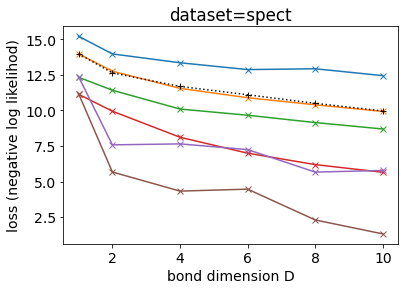

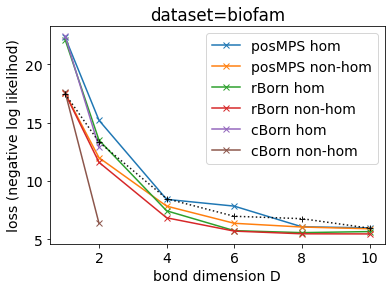

,1,2,4,6,8,10
posMPS hom,22.3,15.20,8.43,7.85,6.08,5.99
posMPS non-hom,17.5,12.00,7.85,6.38,6.06,5.91
rBorn hom,22.1,13.50,7.45,5.75,5.58,5.67
rBorn non-hom,17.5,11.60,6.85,5.71,5.48,5.47
cBorn hom,22.4,12.90,NaN,NaN,NaN,NaN
cBorn non-hom,17.6,6.38,NaN,NaN,NaN,NaN


In [261]:
import pandas as pd
plt.rcParams.update({'font.size': 14}) # font.size change from default 10
index = [1,2,4,6,8,10]
frame=pd.DataFrame()
frame['posMPS hom']=    pd.Series([15.225593, 13.981824, 13.359402, 12.879319, 12.936084, 12.451607], index=index)
frame['posMPS non-hom']=pd.Series([13.986147, 12.764120, 11.556882, 10.896993, 10.399844, 9.931520], index=index)
frame['rBorn hom']=     pd.Series([12.337878, 11.426547, 10.101237, 9.665511, 9.149446, 8.696818], index=index)
frame['rBorn non-hom']= pd.Series([11.142219, 9.950571, 8.116511, 6.995655, 6.190347, 5.649225], index=index)
frame['cBorn hom']=     pd.Series([12.384717, 7.581070, 7.648918, 7.246690, 5.662558, 5.779628], index=index)
frame['cBorn non-hom']= pd.Series([11.188754, 5.670460, 4.325637, 4.462535, 2.293139, 1.312038], index=index)
frame.plot(
    xlabel="bond dimension D", ylabel="loss (negative log likelihod)", marker='x', title="dataset=spect", legend=None)
hmm=pd.Series([13.993, 12.649, 11.695, 11.106, 10.505, 9.968], index=index)
plt.plot(hmm, "+:k", label='HMM', alpha=0.9)
# plt.legend(title="model", bbox_to_anchor=(1.01, 1), loc='upper left', framealpha=0.5, borderaxespad=0.)
plt.show()

index = [1,2,4,6,8,10]
frame=pd.DataFrame()
frame['posMPS hom']=    pd.Series([22.3, 15.2, 8.43, 7.85, 6.08, 5.99], index=index)
frame['posMPS non-hom']=pd.Series([17.5, 12, 7.85, 6.38, 6.06, 5.91], index=index)
frame['rBorn hom']=     pd.Series([22.1, 13.5, 7.45, 5.75, 5.58, 5.67], index=index)
frame['rBorn non-hom']= pd.Series([17.5, 11.6, 6.85, 5.71, 5.48, 5.47], index=index)
frame['cBorn hom']=     pd.Series([22.4, 12.9, None, None, None, None], index=index)
frame['cBorn non-hom']= pd.Series([17.6, 6.38, None, None, None, None], index=index)
#frame['HMM']= pd.Series([17.464, 13.337, 8.485, 6.981, 6.776, 5.963], index=index)
frame.plot(
    xlabel="bond dimension D", ylabel="loss (negative log likelihod)", marker='x')
#plt.legend(title="model (dataset=biofam)", bbox_to_anchor=(.5, 1.01), loc='lower center', framealpha=0.5, ncol=3, borderaxespad=0.)
plt.rcParams.update({'font.size': 14})
hmm=pd.Series([17.464, 13.337, 8.485, 6.981, 6.776, 5.963], index=index)
plt.plot(hmm, "+:k", label='HMM', alpha=0.9)
plt.title("dataset=biofam")
plt.show()

frame.transpose()

In [262]:
ax

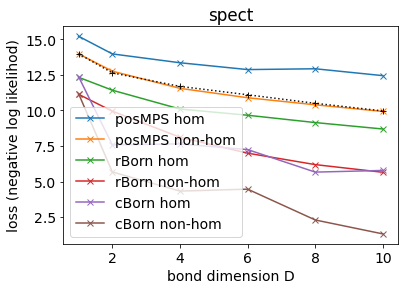

,1,2,4,6,8,10
posMPS hom,15.225593,13.981824,13.359402,12.879319,12.936084,12.451607
posMPS non-hom,13.986147,12.764120,11.556882,10.896993,10.399844,9.931520
rBorn hom,12.337878,11.426547,10.101237,9.665511,9.149446,8.696818
rBorn non-hom,11.142219,9.950571,8.116511,6.995655,6.190347,5.649225
cBorn hom,12.384717,7.581070,7.648918,7.246690,5.662558,5.779628
cBorn non-hom,11.188754,5.670460,4.325637,4.462535,2.293139,1.312038


In [257]:
import pandas as pd
df_spect = pd.DataFrame({
    1: pd.DataFrame(lossvals1).iloc[-1],
    2: pd.DataFrame(lossvals2).iloc[-1],
    4: pd.DataFrame(lossvals4).iloc[-1],
    6: pd.DataFrame(lossvals6).iloc[-1],
    8: pd.DataFrame(lossvals8).iloc[-1],
    10: pd.DataFrame(lossvals10).iloc[-1]
    }).transpose()
df_spect.plot(xlabel="bond dimension D", ylabel="loss (negative log likelihod)", marker='x')
hmm=pd.Series([13.993, 12.649, 11.695, 11.106, 10.505, 9.968], index=index)
plt.plot(hmm, "+:k", label='HMM', alpha=0.9)
plt.title("spect")
# plt.legend(title="model (dataset=spect)", bbox_to_anchor=(.5, 1.01), loc='lower center', framealpha=0.5, ncol=3, borderaxespad=0.)
plt.show()
frame.transpose()

In [3]:
dataset = 'lymphography'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)
# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)

lossvals = train_models(
    [#mps_s, mps_s_hom, rBorn_s, rBorn_s_hom, 
    cBorn_s, cBorn_s_hom
    ],
    clamp_at=None, batchsize=50, max_epochs=2000, batched=True, optimizer=torch.optim.Adam, lr=1e-6)

In [21]:
dataset = 'flare'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals = train_models(
    [mps_s, mps_s_hom, rBorn_s, rBorn_s_hom, cBorn_s, cBorn_s_hom],
    clamp_at=None, batchsize=20, max_epochs=2, batched=True, optimizer=torch.optim.Adam, lr=1e-5)

-----------------

╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.516 15.109 14.855 14.645 14.387 14.242 14.160 14.123 14.060 14.022 14.041 13.980 13.996 13.976 14.014 14.009 13.993 13.975 13.956 13.968 13.943 13.970 13.979 13.940 13.975 13.988 13.962 14.003 13.939 13.947 13.946 13.943 13.934 13.957 13.959 13.939 13.913 13.952 13.941 13.944 13.915 13.926 13.895 13.875 13.909 13.902 13.897 13.898 13.861 13.842 13.829 13.780 13.749 13.660 13.618 13.607 13.566 13.503 13.500 13.475 13.478 13.465 13.428 13.448 13.439 13.443 13.429 13.427 13.379 13.373 13.373 13.403 13.381 13.387 13.350 13.361 13.346 13.310 13.328 13.282 13.286 13.287 13.216 13.273 13.243 13.241 13.175 13.191 13.139 13.144 13.189 13.200 13.107 13.109 13.100 13.078 13.080 13.084 13.063 13.031 13.039 13.087 13.046 13.036 13.048 13.037 13.008 12.983 13.018 13.019 13.007 12.987 13.002 12.987 13.007 13.001 12.985 13.021 12.963 12.982 12.932 12.958 12.971 12.963 12.922 12.947 12.894 12.935 12.881 12.886 12.923 12.886 12.949 12.914 12.921 12.915 12.897 12.886 12.869 12.877 12.8


│ loss values: 15.117 14.086 13.854 13.729 13.604 13.550 13.476 13.421 13.410 13.385 13.359 13.345 13.304 13.313 13.312 13.319 13.317 13.296 13.275 13.277 13.292 13.257 13.272 13.233 13.243 13.208 13.207 13.196 13.187 13.160 13.120 13.101 13.036 12.995 12.938 12.919 12.917 12.883 12.914 12.872 12.873 12.817 12.813 12.792 12.774 12.799 12.741 12.713 12.697 12.645 12.609 12.569 12.547 12.482 12.430 12.360 12.324 12.290 12.241 12.204 12.156 12.182 12.129 12.121 12.056 12.044 11.999 11.982 11.966 11.924 11.935 11.896 11.863 11.824 11.831 11.837 11.754 11.757 11.719 11.672 11.686 11.634 11.633 11.634 11.617 11.613 11.562 11.577 11.588 11.557 11.550 11.530 11.507 11.483 11.484 11.471 11.452 11.475 11.456 11.459 11.420 11.407 11.419 11.380 11.394 11.365 11.347 11.325 11.320 11.354 11.288 11.281 11.305 11.274 11.265 11.264 11.239 11.268 11.241 11.225 11.222 11.188 11.201 11.167 11.201 11.154 11.131 11.146 11.141 11.125 11.118 11.096 11.116 11.095 11.077 11.072 11.065 11.081 11.027 11.031 11.0


│ loss values: 15.381 14.745 14.598 14.397 14.103 13.937 13.798 13.733 13.668 13.587 13.608 13.524 13.525 13.541 13.517 13.513 13.487 13.459 13.418 13.410 13.424 13.413 13.385 13.363 13.375 13.405 13.387 13.374 13.332 13.330 13.338 13.289 13.259 13.337 13.284 13.257 13.352 13.266 13.239 13.232 13.238 13.231 13.187 13.214 13.207 13.183 13.185 13.158 13.146 13.150 13.125 13.147 13.126 13.113 13.134 13.084 13.068 13.120 13.094 13.098 13.092 13.062 13.068 13.038 13.081 13.074 13.033 12.984 13.008 13.017 12.975 12.938 12.963 12.978 12.980 12.935 12.974 12.987 12.950 12.906 12.887 12.894 12.853 12.831 12.837 12.835 12.744 12.720 12.611 12.467 12.377 12.291 12.099 12.081 12.008 11.989 11.919 11.959 11.915 11.940 11.942 11.917 11.842 11.830 11.822 11.825 11.852 11.925 11.813 11.769 11.871 11.847 11.797 11.761 11.737 11.784 11.795 11.700 11.698 11.673 11.710 11.669 11.704 11.673 11.644 11.614 11.671 11.646 11.660 11.712 11.626 11.552 11.502 11.548 11.508 11.493 11.515 11.509 11.517 11.600 11.4


│ loss values: 14.641 13.816 13.689 13.639 13.502 13.429 13.320 13.214 13.146 13.109 13.056 13.042 12.978 12.944 12.943 12.920 12.930 12.919 12.892 12.920 12.819 12.861 12.821 12.818 12.812 12.779 12.807 12.796 12.719 12.737 12.759 12.718 12.738 12.678 12.627 12.679 12.662 12.638 12.643 12.619 12.589 12.607 12.570 12.570 12.543 12.558 12.508 12.535 12.508 12.527 12.538 12.514 12.530 12.497 12.474 12.431 12.413 12.435 12.396 12.422 12.385 12.356 12.381 12.338 12.337 12.341 12.329 12.303 12.285 12.312 12.282 12.262 12.245 12.214 12.229 12.194 12.243 12.195 12.134 12.089 12.116 12.053 12.016 11.987 11.880 11.819 11.776 11.797 11.705 11.746 11.706 11.689 11.669 11.701 11.613 11.619 11.595 11.531 11.462 11.433 11.384 11.268 11.205 11.121 11.044 11.023 10.966 10.936 10.909 10.831 10.823 10.857 10.867 10.799 10.792 10.725 10.747 10.692 10.657 10.673 10.649 10.614 10.625 10.556 10.550 10.552 10.496 10.522 10.439 10.441 10.444 10.385 10.364 10.320 10.315 10.285 10.264 10.240 10.203 10.165 10.1

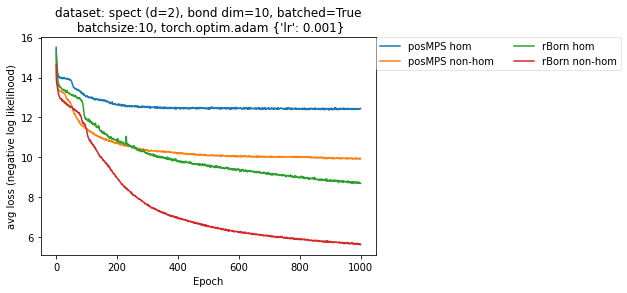

In [98]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 10

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals10 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s
    cBorn_s_hom, cBorn_s
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.708 14.939 14.721 14.504 14.376 14.294 14.221 14.154 14.112 14.069 14.053 14.036 13.987 14.014 14.001 13.978 13.975 13.992 13.978 13.977 13.974 13.953 13.948 13.955 13.969 13.992 13.983 13.969 13.977 13.963 13.969 13.951 13.961 13.925 13.959 13.940 13.973 13.922 13.937 13.968 13.953 13.955 13.932 13.960 13.945 13.972 13.956 13.951 13.950 13.925 13.925 13.937 13.927 13.927 13.937 13.937 13.935 13.910 13.914 13.894 13.908 13.932 13.896 13.887 13.933 13.916 13.905 13.902 13.910 13.889 13.874 13.889 13.885 13.892 13.887 13.902 13.898 13.874 13.924 13.849 13.876 13.832 13.896 13.874 13.808 13.855 13.852 13.843 13.797 13.814 13.835 13.854 13.811 13.818 13.769 13.742 13.739 13.687 13.675 13.674 13.648 13.650 13.579 13.556 13.545 13.480 13.510 13.479 13.439 13.423 13.442 13.392 13.368 13.413 13.340 13.296 13.324 13.354 13.315 13.275 13.247 13.298 13.285 13.223 13.249 13.240 13.270 13.234 13.235 13.253 13.273 13.224 13.220 13.236 13.255 13.214 13.248 13.208 13.223 13.217 13.1


│ loss values: 15.082 14.171 13.885 13.744 13.655 13.562 13.507 13.452 13.417 13.359 13.372 13.336 13.323 13.341 13.323 13.313 13.319 13.269 13.298 13.268 13.302 13.269 13.255 13.279 13.283 13.226 13.204 13.230 13.181 13.172 13.159 13.185 13.155 13.115 13.101 13.066 13.048 13.046 12.975 12.957 12.920 12.896 12.866 12.815 12.786 12.743 12.700 12.639 12.582 12.576 12.542 12.500 12.447 12.419 12.410 12.363 12.363 12.266 12.288 12.263 12.241 12.196 12.166 12.191 12.153 12.087 12.081 12.065 12.093 12.055 12.021 12.022 11.978 12.025 12.007 12.001 11.975 11.938 11.963 11.932 11.934 11.957 11.919 11.904 11.869 11.864 11.904 11.879 11.809 11.826 11.827 11.806 11.789 11.777 11.743 11.806 11.764 11.767 11.757 11.741 11.703 11.733 11.714 11.670 11.677 11.699 11.647 11.643 11.657 11.650 11.623 11.612 11.644 11.576 11.599 11.648 11.596 11.587 11.569 11.551 11.575 11.570 11.529 11.546 11.547 11.528 11.517 11.498 11.530 11.456 11.487 11.466 11.465 11.465 11.453 11.454 11.398 11.391 11.397 11.393 11.3


│ loss values: 14.937 14.743 14.541 14.291 14.107 13.999 13.869 13.827 13.736 13.708 13.656 13.609 13.622 13.581 13.600 13.552 13.569 13.561 13.530 13.525 13.494 13.507 13.500 13.502 13.485 13.460 13.460 13.465 13.443 13.410 13.381 13.389 13.380 13.362 13.364 13.386 13.329 13.323 13.348 13.310 13.285 13.295 13.321 13.303 13.264 13.258 13.237 13.240 13.227 13.220 13.198 13.178 13.206 13.159 13.158 13.103 13.072 13.010 12.972 12.929 12.834 12.718 12.688 12.630 12.720 12.900 12.804 12.639 12.554 12.467 12.353 12.292 12.267 12.194 12.172 12.215 12.205 12.145 12.119 12.127 12.091 12.064 12.049 12.045 12.067 12.010 12.035 11.980 12.005 11.984 11.992 11.979 11.924 11.924 11.939 11.921 11.880 11.883 11.894 11.894 11.893 11.860 11.833 11.895 11.869 11.861 11.798 11.823 11.810 11.790 11.795 11.768 11.743 11.722 11.736 11.675 11.689 11.691 11.679 11.658 11.659 11.634 11.661 11.641 11.639 11.571 11.573 11.500 11.473 11.506 11.481 11.445 11.433 11.487 11.472 11.374 11.383 11.402 11.366 11.375 11.2


│ loss values: 15.088 13.987 13.763 13.642 13.636 13.529 13.465 13.358 13.325 13.240 13.184 13.119 13.086 13.058 13.033 12.973 13.000 12.962 12.967 12.906 12.894 12.910 12.882 12.861 12.856 12.826 12.798 12.810 12.824 12.773 12.771 12.738 12.765 12.737 12.735 12.693 12.723 12.692 12.677 12.653 12.651 12.653 12.621 12.619 12.612 12.589 12.595 12.582 12.559 12.585 12.543 12.557 12.565 12.533 12.497 12.520 12.513 12.474 12.528 12.449 12.476 12.448 12.442 12.471 12.421 12.410 12.392 12.399 12.361 12.360 12.375 12.368 12.346 12.367 12.323 12.296 12.320 12.320 12.282 12.288 12.260 12.243 12.246 12.190 12.223 12.209 12.217 12.223 12.202 12.197 12.190 12.192 12.162 12.087 12.183 12.139 12.116 12.107 12.094 12.049 12.059 12.024 11.969 11.958 11.925 11.891 11.795 11.743 11.692 11.630 11.586 11.533 11.568 11.445 11.418 11.409 11.379 11.369 11.342 11.317 11.302 11.280 11.259 11.213 11.234 11.142 11.184 11.101 11.109 11.044 10.947 10.927 10.875 10.829 10.824 10.778 10.723 10.696 10.717 10.639 10.5

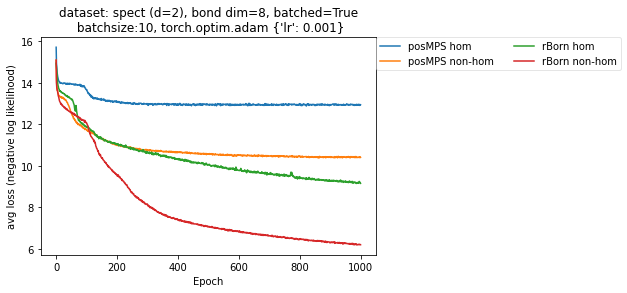

In [4]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals8 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s
    cBorn_s_hom, cBorn_s
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.329 15.047 14.896 14.761 14.615 14.558 14.444 14.396 14.348 14.270 14.247 14.177 14.143 14.101 14.099 14.074 14.046 14.056 14.025 13.984 13.978 13.995 14.012 13.987 13.985 13.978 13.996 13.979 13.974 13.964 13.985 13.975 13.980 13.969 13.983 13.985 13.986 13.964 13.964 13.983 13.933 13.981 13.943 13.949 13.954 13.946 13.949 13.956 13.956 13.939 13.984 13.950 13.918 13.929 13.922 13.947 13.930 13.960 13.933 13.931 13.922 13.953 13.932 13.916 13.965 13.935 13.933 13.937 13.929 13.924 13.894 13.936 13.928 13.905 13.940 13.911 13.916 13.932 13.931 13.915 13.933 13.954 13.951 13.935 13.902 13.925 13.909 13.927 13.916 13.919 13.914 13.930 13.869 13.910 13.925 13.918 13.908 13.872 13.870 13.873 13.902 13.817 13.827 13.783 13.711 13.601 13.550 13.460 13.427 13.424 13.366 13.346 13.331 13.338 13.374 13.325 13.319 13.329 13.290 13.293 13.313 13.295 13.303 13.308 13.267 13.281 13.273 13.267 13.278 13.259 13.299 13.286 13.246 13.310 13.213 13.261 13.223 13.291 13.244 13.275 13.2


│ loss values: 15.278 14.402 13.995 13.826 13.725 13.641 13.576 13.497 13.472 13.444 13.423 13.412 13.367 13.350 13.300 13.317 13.323 13.319 13.309 13.332 13.290 13.252 13.250 13.236 13.220 13.242 13.277 13.229 13.208 13.224 13.239 13.223 13.202 13.219 13.189 13.182 13.172 13.182 13.128 13.108 13.065 13.042 12.969 12.900 12.927 12.860 12.871 12.838 12.799 12.746 12.787 12.718 12.742 12.648 12.654 12.624 12.590 12.635 12.544 12.536 12.544 12.507 12.460 12.441 12.474 12.462 12.421 12.459 12.375 12.379 12.391 12.381 12.338 12.337 12.332 12.322 12.256 12.278 12.246 12.205 12.197 12.173 12.146 12.167 12.074 12.102 12.082 12.060 12.061 12.050 12.041 12.008 12.030 11.992 11.967 11.947 11.931 11.907 11.971 11.950 11.901 11.912 11.893 11.920 11.835 11.897 11.864 11.876 11.825 11.855 11.849 11.818 11.835 11.814 11.783 11.787 11.802 11.800 11.799 11.788 11.797 11.788 11.796 11.731 11.755 11.766 11.734 11.727 11.731 11.738 11.721 11.705 11.709 11.692 11.693 11.671 11.707 11.681 11.669 11.686 11.6


│ loss values: 15.016 14.846 14.742 14.644 14.510 14.367 14.210 14.040 13.924 13.855 13.771 13.742 13.657 13.617 13.588 13.597 13.528 13.515 13.486 13.433 13.438 13.406 13.418 13.394 13.419 13.364 13.359 13.362 13.334 13.373 13.332 13.317 13.286 13.271 13.277 13.294 13.271 13.282 13.247 13.267 13.242 13.199 13.208 13.196 13.201 13.183 13.166 13.171 13.133 13.174 13.154 13.120 13.148 13.148 13.113 13.125 13.125 13.128 13.124 13.075 13.107 13.084 13.053 13.057 13.065 13.015 13.027 13.015 13.032 13.023 12.998 13.015 12.993 13.028 12.960 13.024 12.978 12.947 12.937 12.986 12.944 12.932 12.919 12.914 12.942 12.920 12.891 12.895 12.899 12.878 12.926 12.864 12.882 12.888 12.896 12.857 12.859 12.860 12.834 12.845 12.824 12.824 12.826 12.792 12.810 12.789 12.810 12.760 12.774 12.762 12.785 12.766 12.767 12.751 12.748 12.751 12.768 12.753 12.714 12.745 12.693 12.728 12.731 12.715 12.699 12.725 12.723 12.733 12.688 12.659 12.665 12.644 12.679 12.663 12.661 12.651 12.632 12.649 12.626 12.644 12.6


│ loss values: 14.777 14.035 13.771 13.733 13.666 13.550 13.518 13.460 13.401 13.331 13.235 13.231 13.142 13.093 13.067 13.025 12.971 13.002 12.918 12.931 12.905 12.925 12.883 12.819 12.861 12.837 12.810 12.838 12.807 12.785 12.789 12.777 12.751 12.763 12.711 12.705 12.717 12.677 12.692 12.693 12.642 12.626 12.661 12.656 12.633 12.610 12.579 12.592 12.562 12.565 12.553 12.546 12.520 12.542 12.538 12.532 12.530 12.490 12.488 12.465 12.435 12.446 12.448 12.427 12.427 12.449 12.400 12.408 12.401 12.401 12.374 12.371 12.321 12.331 12.342 12.332 12.327 12.327 12.330 12.317 12.285 12.347 12.313 12.293 12.281 12.230 12.258 12.255 12.264 12.226 12.193 12.204 12.215 12.210 12.168 12.152 12.158 12.121 12.135 12.097 12.060 12.094 12.064 12.052 12.063 11.990 11.997 11.988 11.990 11.979 11.948 11.960 11.894 11.878 11.836 11.880 11.849 11.825 11.786 11.775 11.749 11.754 11.724 11.747 11.710 11.704 11.658 11.654 11.648 11.667 11.639 11.612 11.604 11.596 11.597 11.549 11.533 11.535 11.510 11.508 11.4

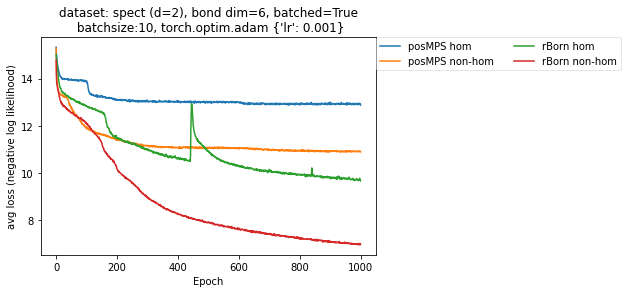

In [5]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 6

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals6 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s
    cBorn_s_hom, cBorn_s
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.368 14.910 14.749 14.677 14.599 14.533 14.495 14.416 14.354 14.339 14.276 14.229 14.222 14.164 14.135 14.108 14.082 14.083 14.068 14.044 14.060 14.042 14.045 13.977 14.015 14.019 13.964 13.998 14.027 13.990 13.978 14.005 14.001 13.998 14.004 13.950 13.978 13.968 13.962 13.992 13.977 13.974 13.975 13.987 13.968 13.957 13.980 13.945 13.953 13.949 13.957 13.955 13.969 13.984 13.951 13.968 13.940 13.952 13.989 13.969 13.938 13.945 13.940 13.966 13.928 13.961 13.954 13.970 13.969 13.935 13.962 13.957 13.966 13.970 13.929 13.969 13.940 13.957 13.947 13.942 13.943 13.933 13.944 13.943 13.944 13.953 13.943 13.955 13.935 13.942 13.935 13.927 13.963 13.943 13.926 13.962 13.934 13.961 13.915 13.964 13.969 13.937 13.949 13.928 13.947 13.972 13.927 13.968 13.943 13.932 13.928 13.943 13.952 13.942 13.916 13.910 13.945 13.957 13.914 13.943 13.917 13.912 13.943 13.930 13.904 13.902 13.911 13.922 13.919 13.930 13.944 13.896 13.936 13.925 13.893 13.945 13.915 13.938 13.918 13.929 13.9


│ loss values: 15.762 14.885 14.361 14.117 13.901 13.805 13.729 13.625 13.610 13.558 13.510 13.508 13.482 13.446 13.428 13.367 13.408 13.362 13.355 13.336 13.343 13.309 13.341 13.295 13.276 13.307 13.279 13.280 13.254 13.246 13.251 13.224 13.231 13.246 13.258 13.277 13.220 13.209 13.248 13.232 13.234 13.203 13.190 13.219 13.180 13.206 13.207 13.193 13.161 13.167 13.141 13.113 13.127 13.124 13.108 13.087 13.094 13.073 13.078 13.052 13.046 13.067 13.035 13.031 13.023 13.021 13.008 13.024 13.017 13.008 12.989 12.964 12.973 13.000 12.957 12.945 12.950 12.908 12.927 12.949 12.958 12.935 12.932 12.955 12.904 12.904 12.900 12.869 12.885 12.874 12.887 12.871 12.864 12.837 12.872 12.854 12.840 12.818 12.794 12.827 12.787 12.821 12.782 12.757 12.802 12.801 12.770 12.740 12.714 12.695 12.706 12.671 12.711 12.685 12.683 12.641 12.587 12.610 12.564 12.579 12.558 12.523 12.511 12.493 12.492 12.452 12.465 12.372 12.383 12.377 12.315 12.323 12.312 12.306 12.289 12.272 12.263 12.256 12.212 12.210 12.2


│ loss values: 15.546 15.155 15.012 14.887 14.770 14.654 14.539 14.388 14.277 14.205 14.127 14.078 14.042 13.958 13.968 13.914 13.859 13.798 13.807 13.754 13.737 13.733 13.675 13.666 13.613 13.608 13.587 13.562 13.573 13.537 13.541 13.517 13.489 13.508 13.444 13.460 13.472 13.460 13.392 13.427 13.436 13.408 13.406 13.415 13.418 13.385 13.371 13.362 13.347 13.329 13.358 13.323 13.361 13.281 13.320 13.325 13.308 13.292 13.279 13.268 13.263 13.269 13.245 13.256 13.223 13.224 13.232 13.224 13.192 13.211 13.184 13.231 13.223 13.164 13.178 13.172 13.159 13.160 13.143 13.101 13.093 13.122 13.100 13.092 13.138 13.092 13.087 13.070 13.094 13.058 13.063 13.094 13.030 13.015 13.044 13.047 13.030 12.998 13.027 12.987 13.010 12.989 13.012 13.002 12.975 12.965 12.955 12.951 12.925 12.944 12.930 12.903 12.906 12.924 12.916 12.916 12.926 12.869 12.903 12.900 12.874 12.885 12.872 12.863 12.867 12.831 12.816 12.850 12.795 12.799 12.855 12.829 12.796 12.791 12.796 12.791 12.819 12.745 12.766 12.747 12.7


│ loss values: 15.706 14.744 14.239 13.941 13.844 13.678 13.611 13.502 13.464 13.403 13.362 13.358 13.298 13.296 13.205 13.185 13.141 13.123 13.081 13.069 13.033 13.004 13.005 12.982 12.978 12.931 12.928 12.934 12.881 12.885 12.833 12.846 12.819 12.821 12.826 12.780 12.792 12.778 12.770 12.739 12.750 12.722 12.712 12.720 12.717 12.694 12.681 12.664 12.620 12.603 12.638 12.646 12.616 12.580 12.612 12.618 12.567 12.560 12.547 12.579 12.518 12.544 12.509 12.535 12.521 12.509 12.463 12.512 12.464 12.415 12.418 12.430 12.453 12.415 12.425 12.399 12.417 12.390 12.397 12.391 12.355 12.356 12.339 12.334 12.343 12.348 12.321 12.308 12.286 12.303 12.284 12.262 12.246 12.278 12.239 12.264 12.240 12.251 12.196 12.166 12.202 12.204 12.167 12.171 12.117 12.148 12.118 12.078 12.094 12.027 11.984 11.982 11.943 11.933 11.908 11.899 11.827 11.829 11.804 11.798 11.778 11.776 11.769 11.761 11.732 11.726 11.727 11.718 11.707 11.727 11.663 11.654 11.688 11.665 11.654 11.651 11.668 11.633 11.628 11.609 11.6

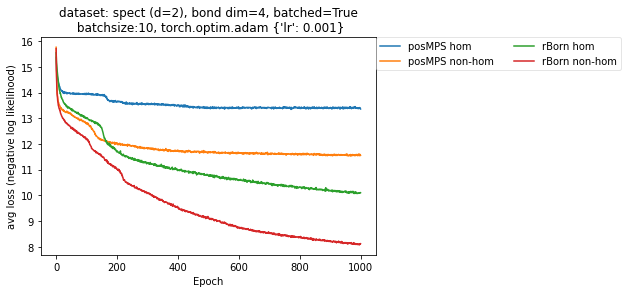

In [6]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 4

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals4 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s
    cBorn_s_hom, cBorn_s
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 16.165 15.925 15.734 15.605 15.540 15.465 15.397 15.300 15.243 15.162 15.077 15.021 14.976 14.892 14.825 14.732 14.693 14.672 14.588 14.548 14.496 14.463 14.425 14.402 14.336 14.312 14.275 14.197 14.163 14.071 14.011 13.932 13.872 13.771 13.662 13.588 13.492 13.373 13.257 13.155 12.998 12.812 12.476 11.200 11.102 11.300 11.499 11.416 11.309 11.436 11.406 11.306 11.379 11.429 11.305 11.289 11.437 11.344 11.219 11.438 11.332 11.231 11.377 11.354 11.219 11.326 11.342 11.276 11.196 11.355 11.295 11.222 11.303 11.325 11.253 11.194 11.399 11.266 11.155 11.308 11.292 11.196 11.181 11.309 11.269 11.104 11.298 11.281 11.201 11.162 11.339 11.236 11.115 11.269 11.228 11.191 11.117 11.300 11.202 11.083 11.214 11.190 11.163 11.086 11.281 11.192 11.071 11.109 11.231 11.172 11.079 11.176 11.163 11.133 11.003 11.282 11.103 11.081 11.070 11.213 11.113 11.060 11.130 11.212 11.112 11.020 11.186 11.127 11.094 11.036 11.226 11.085 11.085 11.008 11.201 11.097 11.047 11.021 11.198 11.083 11.0


│ loss values: 16.595 15.943 15.422 15.038 14.753 14.511 14.344 14.216 14.095 14.015 13.954 13.848 13.784 13.772 13.690 13.686 13.640 13.574 13.523 13.487 13.409 13.400 13.330 13.291 13.222 13.173 13.092 13.003 12.927 12.835 12.713 12.584 12.269 11.735 10.282 10.667 10.314 10.474 10.402 10.387 10.462 10.384 10.389 10.413 10.378 10.425 10.391 10.384 10.419 10.401 10.398 10.382 10.367 10.404 10.382 10.362 10.408 10.394 10.378 10.351 10.386 10.399 10.344 10.402 10.373 10.334 10.376 10.375 10.368 10.384 10.357 10.384 10.326 10.373 10.347 10.356 10.382 10.365 10.391 10.334 10.401 10.359 10.344 10.374 10.358 10.389 10.361 10.128 10.353 10.114 10.156 10.242 10.157 10.040 9.919 9.626 9.732 9.846 9.914 9.868 9.792 9.760 9.834 9.928 9.874 9.807 9.801 9.782 9.914 9.791 9.865 10.105 9.608 9.991 9.769 10.066 10.015 9.937 8.676 9.507 10.663 10.079 9.160 9.097 9.092 9.194 9.277 9.301 9.455 9.487 9.489 9.499 9.513 9.476 9.453 9.501 9.465 9.486 9.465 9.489 9.435 9.450 9.479 9.430 9.457 9.396 9.468 9.3

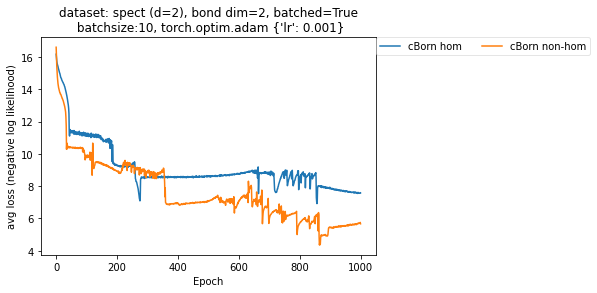

In [132]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 2

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals_c2 = train_models(
    [#mps_s_hom, mps_s, rBorn_s_hom, rBorn_s
    cBorn_s_hom, cBorn_s
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 16.817 16.532 16.292 16.098 15.944 15.815 15.706 15.622 15.571 15.483 15.459 15.434 15.386 15.338 15.340 15.302 15.267 15.274 15.255 15.215 15.226 15.214 15.189 15.187 15.163 15.125 15.127 15.096 15.131 15.079 15.081 15.076 15.084 15.056 15.037 15.040 15.014 14.994 15.002 14.972 14.967 14.983 14.935 14.940 14.939 14.905 14.892 14.886 14.882 14.882 14.865 14.872 14.825 14.849 14.820 14.824 14.799 14.799 14.765 14.782 14.761 14.775 14.759 14.778 14.738 14.753 14.753 14.694 14.701 14.712 14.684 14.674 14.664 14.668 14.666 14.633 14.645 14.661 14.630 14.620 14.642 14.599 14.579 14.597 14.587 14.594 14.587 14.582 14.600 14.535 14.545 14.541 14.553 14.517 14.522 14.521 14.510 14.504 14.501 14.494 14.500 14.477 14.450 14.463 14.458 14.460 14.476 14.437 14.451 14.453 14.429 14.403 14.439 14.410 14.393 14.396 14.402 14.373 14.358 14.361 14.358 14.348 14.369 14.357 14.362 14.340 14.320 14.314 14.303 14.316 14.308 14.315 14.314 14.280 14.314 14.287 14.308 14.283 14.291 14.254 14.2


│ loss values: 21.839 21.087 20.365 19.757 19.180 18.680 18.253 17.851 17.493 17.158 16.875 16.591 16.343 16.129 15.918 15.722 15.563 15.411 15.254 15.118 15.018 14.895 14.793 14.721 14.640 14.548 14.481 14.419 14.375 14.344 14.261 14.218 14.196 14.134 14.124 14.090 14.058 14.041 14.012 13.960 13.965 13.945 13.922 13.887 13.888 13.872 13.842 13.835 13.848 13.831 13.785 13.773 13.754 13.722 13.767 13.744 13.731 13.708 13.705 13.663 13.675 13.680 13.656 13.622 13.609 13.599 13.593 13.565 13.563 13.576 13.580 13.552 13.550 13.560 13.532 13.542 13.498 13.485 13.490 13.528 13.491 13.466 13.461 13.454 13.453 13.429 13.422 13.418 13.417 13.425 13.391 13.402 13.412 13.388 13.361 13.366 13.348 13.335 13.376 13.373 13.329 13.328 13.323 13.348 13.301 13.300 13.302 13.282 13.293 13.312 13.255 13.239 13.281 13.233 13.241 13.254 13.218 13.240 13.230 13.268 13.206 13.192 13.196 13.212 13.192 13.195 13.167 13.177 13.140 13.153 13.171 13.143 13.158 13.171 13.115 13.111 13.121 13.134 13.113 13.127 13.0

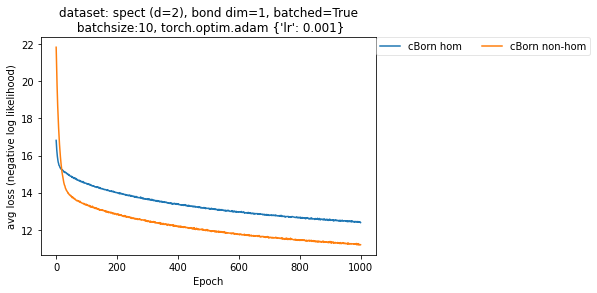

In [133]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 1

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals_c1 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s
    cBorn_s_hom, cBorn_s
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)

╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 16.576 15.594 15.227 15.174 15.043 15.007 14.914 14.787 14.691 14.586 14.493 14.397 14.328 14.230 14.185 14.096 14.066 13.979 13.954 13.889 13.786 13.727 13.646 13.590 13.503 13.408 13.312 13.236 13.177 13.009 12.917 12.656 12.283 10.406 10.493 9.166 9.456 10.318 9.949 11.786 11.624 11.092 9.902 9.230 8.815 8.312 8.016 8.944 9.151 8.687 8.598 9.618 9.409 8.971 9.007 8.975 8.952 8.997 8.993 8.993 8.983 9.012 8.997 9.029 9.031 9.011 9.008 8.957 9.052 9.072 9.096 9.048 9.068 9.047 9.087 9.105 8.997 8.869 8.925 8.915 8.981 8.980 9.011 9.032 9.075 9.052 9.079 9.155 9.142 9.177 9.182 9.222 9.201 9.210 9.222 9.287 9.255 9.281 9.295 9.304 9.268 9.352 9.317 9.338 9.351 9.353 9.397 9.369 9.393 9.384 9.389 9.464 9.406 9.430 9.212 9.221 9.311 9.240 9.349 9.368 9.298 9.471 9.467 9.491 9.567 9.631 9.573 9.657 9.854 9.805 9.720 10.002 9.698 10.010 9.817 9.897 9.751 10.078 9.942 9.915 9.440 8.797 8.896 8.695 8.643 8.751 8.749 8.791 8.822 8.858 8.853 8.850 8.875 8.897 8.919 8.926 8.941 


│ loss values: 15.346 14.495 14.017 13.806 13.682 13.560 13.547 13.452 13.289 13.276 13.202 13.072 13.011 12.947 12.825 12.713 12.588 12.418 12.163 11.870 11.346 9.821 10.343 10.296 10.235 10.234 10.140 10.186 10.079 10.143 10.123 10.071 10.124 10.082 10.126 10.008 10.098 9.960 10.041 9.899 9.969 9.934 9.950 9.916 9.910 9.959 9.840 9.956 9.874 9.954 9.820 9.947 9.810 9.918 9.734 9.707 9.704 9.777 9.823 9.994 9.969 10.018 10.051 9.987 9.826 9.908 9.915 9.622 9.041 9.170 9.668 9.788 9.832 9.849 9.451 9.524 9.592 9.634 9.654 9.692 9.702 9.758 9.768 9.725 9.787 9.673 9.715 9.676 9.262 9.652 9.676 9.684 9.561 9.579 9.553 8.874 9.401 9.515 9.522 9.478 9.446 9.447 9.371 9.370 9.337 9.289 9.364 9.232 9.171 9.226 9.065 9.210 8.759 8.610 8.219 8.025 7.163 7.689 7.949 8.000 7.929 7.938 7.923 7.921 7.896 7.817 7.799 7.753 7.772 7.711 7.674 7.605 7.582 7.522 7.464 7.461 7.388 7.410 7.350 7.380 7.295 7.237 7.194 7.241 7.219 7.200 7.218 7.180 7.232 7.101 7.094 7.044 6.923 6.658 6.433 6.237 6.268 6.2

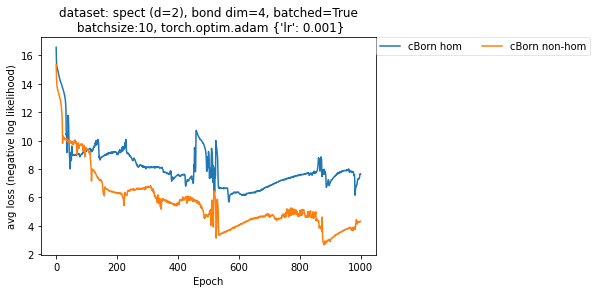

In [134]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 4

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

cBorn_s4    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom4= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals_c4 = train_models(
    [cBorn_s_hom4, cBorn_s4
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.314 15.063 14.869 14.690 14.441 14.282 14.140 14.016 13.885 13.761 13.628 13.484 13.348 13.235 13.081 12.859 12.537 11.283 10.469 11.444 10.928 9.039 9.378 10.422 9.155 10.743 9.170 9.692 11.610 11.706 11.604 11.563 11.516 11.451 11.363 11.236 11.114 10.962 10.691 10.120 8.915 9.613 8.611 8.242 10.056 9.031 8.470 10.717 11.674 11.419 11.005 10.238 8.588 10.296 11.055 10.768 10.077 8.617 9.294 9.573 8.185 10.557 9.871 9.904 12.804 12.424 11.941 11.672 11.522 11.367 11.218 10.961 10.602 8.971 8.106 8.495 10.814 10.552 9.806 7.972 10.371 10.756 10.556 10.152 9.082 8.883 10.804 10.888 10.694 10.374 9.223 10.034 9.275 11.970 12.857 12.655 12.529 12.328 12.196 12.125 12.008 11.882 11.821 11.717 11.605 11.484 11.370 11.207 10.991 10.603 9.571 8.810 8.864 7.941 10.466 10.738 10.519 10.018 9.499 12.812 12.956 12.689 12.415 12.234 12.081 12.018 11.929 11.869 11.815 11.796 11.733 11.693 11.685 11.669 11.637 11.576 11.547 11.516 11.492 11.422 11.376 11.330 11.298 11.243 11.177 1


│ loss values: 14.993 14.051 13.715 13.622 13.504 13.429 13.339 13.270 13.137 13.095 13.043 12.939 12.851 12.741 12.700 12.598 12.512 12.262 11.026 9.501 9.314 8.751 8.299 8.003 7.949 7.725 8.180 8.417 8.400 8.389 8.388 8.400 8.348 8.311 8.238 8.185 8.093 7.930 7.561 7.481 8.429 8.536 8.422 10.000 9.567 8.283 8.116 8.104 8.114 8.136 8.165 8.180 8.179 8.225 8.293 8.255 8.322 8.324 8.334 8.299 8.315 8.361 8.361 8.345 8.358 8.346 8.371 8.378 8.344 8.331 8.392 8.399 8.334 8.386 8.355 8.348 8.394 8.391 8.429 8.426 8.447 8.416 8.410 8.437 8.373 8.387 8.421 8.415 8.442 8.365 8.349 8.292 8.357 8.272 8.225 8.170 8.158 8.107 8.080 8.024 7.960 7.896 7.823 7.775 7.718 7.746 7.717 7.700 7.626 7.661 7.658 7.608 7.581 7.548 7.534 7.479 7.496 7.465 7.437 7.439 7.427 7.420 7.313 7.348 7.288 7.246 7.194 7.208 7.199 7.146 7.041 7.014 6.954 6.994 6.923 6.904 6.851 6.911 6.837 6.872 6.881 6.819 6.804 6.780 6.892 6.731 6.720 6.821 6.779 6.708 6.745 6.700 6.785 6.713 6.759 6.783 6.674 6.740 6.796 6.796 6.84

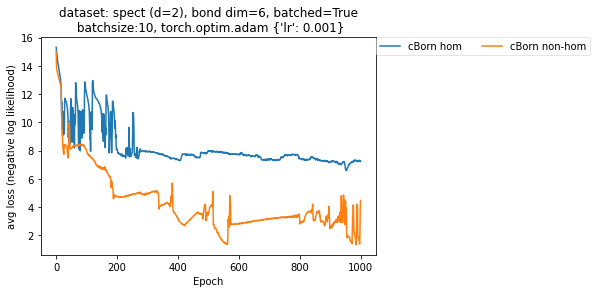

In [135]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 6

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

cBorn_s6    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom6= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals_c6 = train_models(
    [cBorn_s_hom6, cBorn_s6
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.276 14.990 14.834 14.629 14.424 14.214 14.095 13.979 13.918 13.880 13.820 13.792 13.742 13.639 13.620 13.579 13.525 13.492 13.474 13.422 13.376 13.335 13.259 13.160 13.016 12.801 12.242 10.519 9.478 9.085 9.298 10.161 10.164 10.141 10.132 10.146 10.158 10.129 10.155 10.115 10.104 10.148 10.122 10.105 10.087 10.102 10.095 10.124 10.129 10.117 10.076 10.135 10.089 10.094 10.102 10.094 10.058 10.046 10.054 10.044 10.100 10.050 9.990 9.972 9.986 10.090 10.016 10.055 10.013 9.977 9.975 9.982 10.003 9.951 9.968 9.939 9.931 9.946 9.950 9.821 9.825 9.902 9.881 9.829 9.881 9.880 9.869 9.801 9.822 9.882 9.872 9.954 9.780 9.897 9.827 9.615 9.680 9.508 9.759 9.609 9.735 9.627 9.447 9.302 9.173 9.216 9.266 9.045 9.238 9.759 9.659 9.443 9.403 9.371 9.359 9.315 9.101 9.069 9.103 8.832 8.625 8.867 9.148 8.089 8.428 8.360 8.378 8.341 8.403 8.388 8.418 8.413 8.399 8.444 8.425 8.348 8.333 8.474 8.482 8.467 8.497 8.499 8.503 8.580 8.544 8.583 8.558 8.582 8.571 8.562 8.617 8.584 8.669 8.


│ loss values: 14.746 13.829 13.596 13.494 13.407 13.290 13.180 13.079 12.936 12.815 12.691 12.529 12.413 11.896 8.766 9.232 9.667 9.466 8.468 8.946 9.121 10.456 10.093 8.210 7.929 10.157 9.480 10.964 11.006 10.664 9.443 9.186 10.420 9.914 9.218 8.789 10.646 10.730 10.352 9.416 10.161 9.878 11.085 11.089 11.017 10.816 10.554 9.730 9.777 9.329 8.190 7.850 7.928 7.937 7.920 7.960 8.020 8.008 7.984 7.988 7.933 8.032 8.062 8.042 8.055 8.006 8.091 8.086 8.046 8.060 8.077 8.075 8.067 8.097 8.080 8.157 8.163 8.199 8.202 8.219 8.190 8.212 8.165 8.254 8.178 8.157 8.143 8.083 8.089 8.035 8.042 7.991 7.957 7.922 7.890 7.820 7.826 7.726 7.652 7.557 7.575 7.565 7.484 7.481 7.444 7.412 7.367 7.352 7.352 7.396 7.386 7.359 7.360 7.295 7.278 7.243 7.180 6.748 6.764 7.261 7.351 7.436 7.428 7.438 7.413 7.323 7.328 7.337 7.329 7.100 6.513 5.817 6.089 6.110 6.118 6.124 6.101 6.116 6.076 6.084 6.085 6.040 6.057 6.085 6.096 6.074 6.058 6.015 6.023 6.042 6.013 6.015 6.018 5.981 5.946 5.953 5.975 5.912 5.948 

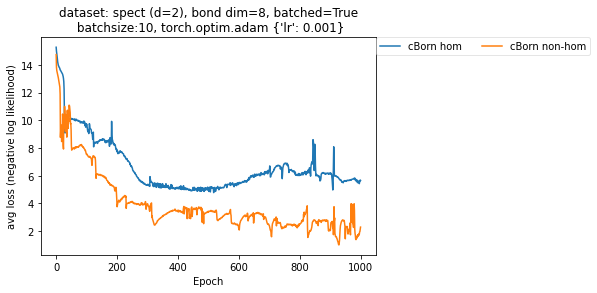

In [136]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

cBorn_s8    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom8= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals_c8 = train_models(
    [cBorn_s_hom8, cBorn_s8
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.193 14.998 14.763 14.449 14.156 14.067 13.888 13.778 13.639 13.475 13.276 13.195 12.839 11.636 10.951 11.687 11.450 11.850 10.834 10.517 10.434 10.483 9.588 9.599 9.802 9.873 9.900 9.968 9.931 9.920 9.909 9.911 9.920 9.828 9.826 9.796 9.723 9.607 9.359 9.009 8.810 8.722 8.657 10.833 9.434 8.658 8.584 8.484 8.534 8.393 8.150 8.012 7.828 9.887 9.471 8.736 8.030 7.911 7.863 7.835 7.904 7.856 7.871 7.713 7.575 7.331 7.311 7.893 10.212 10.256 8.713 8.979 9.634 8.236 8.096 8.123 8.137 8.129 8.057 8.023 8.039 8.003 8.002 7.987 7.926 7.873 7.761 7.696 7.609 7.555 7.433 7.416 7.397 7.373 7.238 7.230 7.234 9.130 8.964 8.426 8.920 8.936 8.955 8.894 8.915 8.876 8.990 8.935 8.942 8.938 8.967 8.930 8.920 8.901 8.924 8.976 8.973 8.882 8.857 8.858 8.912 8.850 8.851 8.873 8.887 8.936 8.960 8.912 8.882 8.914 8.878 8.858 8.879 8.883 8.871 8.791 8.738 8.798 8.852 8.759 8.788 8.786 8.743 8.690 8.709 8.669 8.662 8.637 8.639 8.676 8.537 8.329 8.258 8.130 8.182 8.026 7.727 7.637 8.186 8.339


│ loss values: 14.760 13.906 13.749 13.667 13.501 13.370 13.235 13.095 12.984 12.897 12.737 12.566 11.591 10.316 9.609 10.410 9.589 11.884 11.879 11.439 10.190 10.155 10.312 9.968 9.573 11.023 10.683 9.077 10.764 10.575 9.595 9.681 8.962 9.133 8.186 7.987 8.092 8.119 9.096 11.421 11.457 11.500 11.439 11.406 11.370 11.301 11.268 11.213 11.168 11.134 11.026 10.934 10.764 10.612 10.313 9.254 8.480 8.050 8.017 7.955 7.945 7.920 7.871 7.927 7.894 7.884 7.902 7.859 7.767 7.658 7.568 7.570 7.517 7.470 7.409 7.400 7.423 7.387 7.470 7.390 7.414 7.332 7.328 7.325 7.226 7.161 7.198 6.989 6.840 6.914 7.240 7.247 7.205 7.195 7.140 7.107 7.093 7.006 6.985 6.930 6.878 6.854 6.863 6.752 6.741 6.703 6.684 6.675 6.621 6.645 6.533 6.581 6.557 6.544 6.476 6.453 6.444 6.350 6.308 6.187 6.234 6.261 6.245 6.223 6.266 6.238 6.236 6.187 6.160 6.042 6.179 6.115 6.083 6.113 6.163 6.128 6.111 6.074 6.100 6.075 6.059 6.037 5.957 5.953 5.872 5.905 5.879 5.878 5.843 5.779 5.749 5.693 5.711 5.685 5.651 5.585 5.606 5

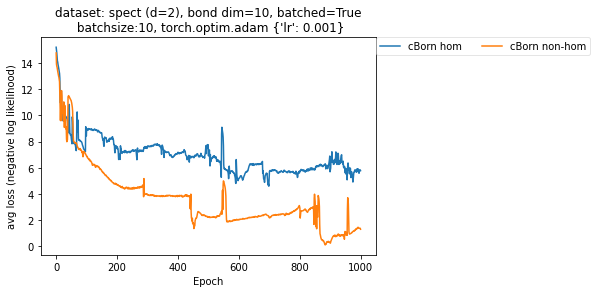

In [137]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 10

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

cBorn_s10    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom10= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals_c10 = train_models(
    [cBorn_s_hom10, cBorn_s10
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, ncol=2, optimizer=torch.optim.Adam, lr=1e-3)


------

╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
dataset: tumor
╭───────────────────────────batched=True
│Training Positive MPS, Non-homogeneous + log_stability, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 1e-05}.



│ loss values: 23.728 23.573 23.419 23.266 23.115 22.965 22.816 22.669 22.523 22.378 22.235 22.093 21.953 21.814 21.675 21.539 21.403 21.269 21.135 21.004 20.874 20.744 20.616 20.488 20.361 20.237 20.113 19.991 19.868 19.749 19.629 19.511 19.394 19.279 19.164 19.052 18.938 18.825 18.717 18.607 18.499 18.391 18.284 18.180 18.075 17.973 17.871 17.769 17.671 17.571 17.471 17.375 17.279 17.185 17.088 16.996 16.903 16.811 16.719 16.630 16.540 16.454 16.366 16.282 16.195 16.110 16.029 15.946 15.866 15.782 15.701 15.624 15.543 15.467 15.391 15.316 15.238 15.166 15.091 15.019 14.947 14.879 14.806 14.738 14.667 14.600 14.533 14.464 14.397 14.334 14.271 14.208 14.144 14.082 14.018 13.960 13.898 13.840 13.783 13.724 13.665 13.607 13.554 13.499 13.443 13.388 13.335 13.285 13.230 13.179 13.128 13.081 13.030 12.978 12.932 12.884 12.832 12.787 12.741 12.696 12.651 12.611 12.561 12.518 12.476 12.435 12.393 12.351 12.307 12.268 12.229 12.195 12.152 12.113 12.077 12.042 12.004 11.965 11.934 11.891 11.8


│ loss values: 23.513 23.372 23.230 23.091 22.953 22.817 22.681 22.548 22.416 22.285 22.155 22.028 21.900 21.775 21.652 21.529 21.408 21.287 21.170 21.052 20.936 20.821 20.707 20.596 20.484 20.376 20.266 20.159 20.054 19.951 19.846 19.743 19.643 19.545 19.445 19.347 19.251 19.156 19.063 18.969 18.877 18.785 18.695 18.610 18.522 18.435 18.350 18.265 18.184 18.101 18.020 17.939 17.862 17.783 17.707 17.631 17.558 17.482 17.408 17.338 17.265 17.198 17.125 17.060 16.992 16.927 16.857 16.798 16.731 16.669 16.610 16.548 16.489 16.427 16.368 16.313 16.257 16.205 16.147 16.090 16.039 15.984 15.935 15.888 15.837 15.781 15.736 15.689 15.640 15.594 15.549 15.502 15.459 15.417 15.370 15.329 15.290 15.245 15.204 15.167 15.132 15.088 15.055 15.015 14.979 14.947 14.912 14.876 14.843 14.807 14.778 14.745 14.711 14.680 14.652 14.620 14.592 14.564 14.534 14.505 14.480 14.448 14.427 14.398 14.377 14.351 14.326 14.303 14.277 14.257 14.232 14.211 14.189 14.166 14.148 14.130 14.109 14.087 14.070 14.053 14.0


│ loss values: 23.643 23.455 23.268 23.085 22.902 22.723 22.545 22.369 22.194 22.023 21.852 21.684 21.518 21.353 21.191 21.028 20.869 20.711 20.556 20.402 20.250 20.099 19.950 19.802 19.655 19.511 19.368 19.226 19.087 18.949 18.811 18.677 18.542 18.410 18.277 18.149 18.020 17.893 17.768 17.644 17.523 17.401 17.281 17.163 17.045 16.928 16.815 16.702 16.588 16.481 16.370 16.262 16.155 16.050 15.943 15.842 15.741 15.639 15.540 15.440 15.345 15.248 15.156 15.059 14.968 14.874 14.785 14.695 14.608 14.521 14.436 14.349 14.267 14.185 14.104 14.023 13.942 13.867 13.788 13.711 13.635 13.563 13.489 13.417 13.345 13.277 13.204 13.136 13.070 13.004 12.938 12.872 12.810 12.746 12.684 12.623 12.562 12.504 12.446 12.389 12.334 12.275 12.223 12.167 12.114 12.062 12.008 11.960 11.912 11.861 11.814 11.764 11.719 11.671 11.627 11.581 11.535 11.493 11.450 11.408 11.371 11.330 11.292 11.249 11.215 11.174 11.136 11.104 11.065 11.029 10.996 10.961 10.926 10.891 10.864 10.829 10.799 10.769 10.741 10.711 10.6


│ loss values: 23.634 23.446 23.262 23.078 22.897 22.719 22.542 22.367 22.194 22.023 21.853 21.686 21.520 21.356 21.194 21.034 20.876 20.718 20.561 20.409 20.257 20.107 19.959 19.810 19.665 19.521 19.378 19.239 19.098 18.960 18.824 18.688 18.556 18.424 18.293 18.163 18.035 17.909 17.785 17.660 17.539 17.417 17.299 17.179 17.065 16.948 16.833 16.721 16.609 16.499 16.389 16.282 16.172 16.068 15.967 15.861 15.759 15.657 15.561 15.462 15.366 15.268 15.172 15.080 14.987 14.896 14.807 14.719 14.629 14.542 14.458 14.370 14.287 14.205 14.122 14.041 13.961 13.885 13.806 13.731 13.655 13.581 13.506 13.436 13.361 13.291 13.224 13.156 13.082 13.018 12.953 12.889 12.824 12.761 12.700 12.636 12.578 12.515 12.458 12.397 12.342 12.285 12.231 12.178 12.121 12.069 12.016 11.968 11.917 11.863 11.815 11.767 11.719 11.675 11.625 11.577 11.535 11.492 11.446 11.407 11.362 11.320 11.280 11.239 11.204 11.161 11.125 11.087 11.051 11.013 10.979 10.943 10.909 10.877 10.842 10.812 10.775 10.748 10.714 10.685 10.6


│ loss values: 22.064 21.910 21.757 21.606 21.458 21.311 21.166 21.023 20.883 20.744 20.607 20.471 20.338 20.206 20.077 19.951 19.824 19.699 19.578 19.455 19.337 19.221 19.105 18.993 18.881 18.770 18.662 18.552 18.450 18.344 18.242 18.139 18.041 17.944 17.847 17.752 17.659 17.569 17.478 17.391 17.301 17.219 17.133 17.045 16.963 16.886 16.807 16.729 16.652 16.576 16.507 16.433 16.359 16.288 16.222 16.154 16.089 16.021 15.958 15.898 15.834 15.776 15.719 15.658 15.601 15.547 15.496 15.440 15.388 15.333 15.285 15.234 15.188 15.140 15.097 15.051 15.008 14.968 14.923 14.879 14.843 14.805 14.763 14.731 14.689 14.655 14.618 14.586 14.556 14.521 14.489 14.457 14.432 14.402 14.373 14.347 14.319 14.296 14.269 14.248 14.219 14.193 14.177 14.149 14.130 14.111 14.092 14.072 14.054 14.032 14.020 13.999 13.986 13.967 13.949 13.941 13.923 13.915 13.900 13.880 13.869 13.862 13.849 13.838 13.829 13.817 13.803 13.796 13.783 13.774 13.764 13.762 13.746 13.738 13.732 13.722 13.715 13.707 13.702 13.698 13.6


│ loss values: 22.794 22.632 22.471 22.314 22.157 22.003 21.851 21.701 21.552 21.405 21.261 21.118 20.976 20.838 20.700 20.564 20.430 20.298 20.168 20.039 19.912 19.787 19.664 19.540 19.421 19.301 19.186 19.069 18.955 18.843 18.733 18.623 18.516 18.409 18.305 18.202 18.102 18.001 17.900 17.807 17.709 17.616 17.521 17.432 17.338 17.250 17.163 17.079 16.994 16.909 16.828 16.749 16.666 16.590 16.516 16.440 16.369 16.289 16.220 16.148 16.081 16.013 15.948 15.880 15.815 15.755 15.693 15.630 15.569 15.512 15.452 15.396 15.338 15.284 15.232 15.178 15.130 15.080 15.033 14.979 14.934 14.882 14.844 14.798 14.752 14.712 14.672 14.629 14.585 14.547 14.512 14.474 14.437 14.404 14.369 14.338 14.301 14.270 14.238 14.214 14.178 14.151 14.122 14.091 14.065 14.041 14.011 13.987 13.968 13.939 13.921 13.895 13.877 13.855 13.836 13.821 13.795 13.775 13.760 13.738 13.726 13.706 13.695 13.681 13.665 13.644 13.634 13.616 13.603 13.593 13.577 13.561 13.554 13.542 13.535 13.522 13.510 13.501 13.492 13.480 13.4

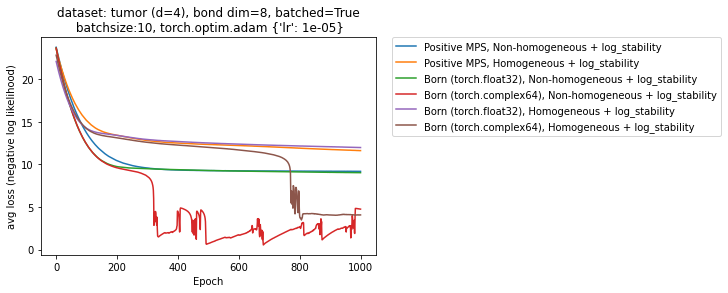

In [6]:
dataset = 'tumor'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals = train_models(
    [mps_s_hom, rBorn_s_hom, cBorn_s_hom, mps_s, rBorn_s, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, optimizer=torch.optim.Adam, lr=1e-5)


╭──votes
│ data shape:(435, 17)
│ range of X values: 0 -- 2
╰───────────────────
dataset: votes
╭───────────────────────────batched=True
│Training Born (torch.complex64), Non-homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 1e-06}.



│ loss values: 18.658 18.647 18.636 18.625 18.614 18.605 18.595 18.583 18.575 18.562 18.552 18.543 18.532 18.521 18.512 18.501 18.492 18.480 18.471 18.461 18.453 18.440 18.431 18.420 18.412 18.402 18.391 18.380 18.371 18.361 18.351 18.342 18.330 18.321 18.314 18.305 18.292 18.282 18.272 18.265 18.255 18.246 18.235 18.224 18.215 18.205 18.197 18.187 18.177 18.167 18.159 18.147 18.140 18.127 18.120 18.113 18.100 18.093 18.083 18.074 18.063 18.054 18.046 18.035 18.027 18.017 18.008 17.998 17.989 17.980 17.971 17.964 17.950 17.944 17.935 17.925 17.917 17.906 17.896 17.893 17.878 17.870 17.861 17.854 17.844 17.835 17.826 17.815 17.808 17.798 17.790 17.781 17.773 17.764 17.754 17.748 17.736 17.728 17.718 17.712 17.704 17.695 17.685 17.676 17.674 17.659 17.649 17.645 17.631 17.625 17.614 17.606 17.598 17.590 17.581 17.574 17.563 17.555 17.548 17.538 17.530 17.522 17.513 17.507 17.496 17.488 17.476 17.470 17.464 17.456 17.445 17.440 17.432 17.428 17.413 17.404 17.395 17.386 17.383 17.377 17.3


│ loss values: 18.289 18.278 18.269 18.260 18.250 18.240 18.229 18.221 18.211 18.203 18.193 18.183 18.172 18.164 18.156 18.144 18.135 18.127 18.117 18.107 18.098 18.089 18.079 18.071 18.062 18.053 18.046 18.035 18.025 18.018 18.008 17.998 17.990 17.983 17.972 17.963 17.956 17.945 17.937 17.930 17.920 17.911 17.905 17.893 17.887 17.876 17.869 17.859 17.852 17.842 17.836 17.826 17.818 17.809 17.801 17.792 17.782 17.777 17.767 17.760 17.753 17.744 17.734 17.729 17.718 17.711 17.706 17.694 17.687 17.678 17.671 17.663 17.654 17.645 17.639 17.630 17.625 17.618 17.607 17.598 17.600 17.584 17.577 17.567 17.560 17.553 17.549 17.537 17.530 17.522 17.515 17.506 17.502 17.490 17.486 17.476 17.468 17.464 17.453 17.449 17.440 17.439 17.424 17.425 17.412 17.402 17.397 17.387 17.387 17.378 17.366 17.359 17.352 17.342 17.340 17.331 17.323 17.316 17.310 17.304 17.296 17.288 17.287 17.277 17.266 17.262 17.253 17.248 17.241 17.244 17.228 17.222 17.213 17.206 17.199 17.194 17.188 17.190 17.170 17.166 17.1

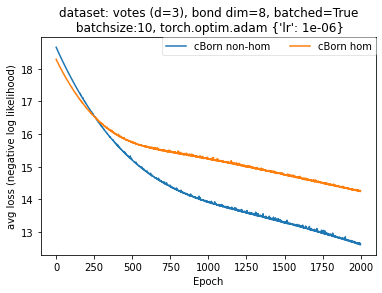

In [20]:
dataset = 'votes'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals = train_models(
    [#mps_s, mps_s_hom, rBorn_s, rBorn_s_hom, 
    cBorn_s, cBorn_s_hom],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, optimizer=torch.optim.Adam, lr=1e-6)


╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
dataset: lymphography
╭───────────────────────────batched=True
│Training Born (torch.float32), Non-homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.025}.


├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([19, 8, 8, 8])
│ loss values: 19.810 16.050 15.240 14.624 14.191 13.884 13.748 13.530 13.286 13.210 12.979 12.827 12.728 12.564 12.434 12.365 12.338 12.106 11.993 11.831 11.692 11.688 11.514 11.395 11.292 11.277 11.214 11.098 11.012 11.040 10.955 10.881 10.766 10.703 10.661 10.694 10.657 10.489 10.495 10.388 10.348 10.295 10.265 10.209 10.149 10.067 10.038 10.003 10.003 9.940 9.868 9.825 9.802 9.772 9.735 9.703 9.705 9.684 9.643 9.588 9.590 9.592 9.531 9.533 9.425 9.471 9.435 9.382 9.388 9.387 9.370 9.334 9.268 9.222 9.246 9.173 9.161 9.170 9.112 9.092 9.029 9.019 9.027 9.006 8.961 8.943 8.870 8.916 8.884 8.862 8.808 8.793 8.821 8.777 8.749 8.747 8.745 8.749 8.705 8.647 8.622 8.655 8.679 8.612 8.590 8.572 8.549 8.533 8.489 8.532 8.490 8.530 8.531 8.451 8.455 8.412 8.404 8.391 8.325 8.358 8.362 8.353 8.233 8.263 8.325

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8, 8, 8])
│ loss values: 29.420 26.176 24.232 23.168 22.414 21.858 21.456 21.056 20.556 20.176 19.782 19.355 19.034 18.770 18.432 18.210 18.214 23.368 26.795 25.911 25.204 26.318 27.621 27.759 26.291 25.479 24.766 24.097 23.598 23.218 22.955 22.707 22.518 22.371 22.126 21.962 21.855 21.759 21.637 21.536 21.474 21.369 21.297 21.200 21.122 21.049 21.019 20.939 20.909 20.814 20.798 20.726 20.665 20.603 20.539 20.519 20.458 20.423 20.355 20.301 20.251 20.201 20.147 20.138 20.074 20.029 19.996 19.958 19.942 19.882 19.870 19.802 19.777 19.744 19.708 19.688 19.606 19.629 19.580 19.543 19.542 19.518 19.503 19.471 19.416 19.429 19.384 19.335 19.352 19.310 19.285 19.252 19.248 19.227 19.211 19.176 19.178 19.155 19.100 19.055 19.052 19.038 19.040 19.056 18.983 18.971 18.940 18.937 18.951 18.919 18.853 18.887 18.877 18.855 18.8

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([19, 8, 8, 8])
│ loss values: 19.754 15.879 14.899 14.238 13.940 13.682 13.409 13.262 13.096 12.997 12.837 12.684 12.423 12.375 12.237 12.065 11.906 11.829 11.734 11.614 11.530 11.386 11.335 11.286 11.160 11.189 11.054 10.952 10.869 10.826 10.809 10.719 10.592 10.533 10.563 10.445 10.387 10.352 10.282 10.181 10.121 10.137 10.046 9.990 9.916 9.965 9.794 9.791 9.807 9.723 9.711 9.651 9.635 9.565 9.581 9.554 9.467 9.525 9.413 9.378 9.350 9.332 9.418 9.307 9.291 9.232 9.237 9.247 9.243 9.165 9.124 9.135 9.127 9.102 9.049 9.045 8.992 8.984 8.968 8.885 8.895 8.869 8.899 8.877 8.844 8.757 8.806 8.752 8.737 8.778 8.721 8.748 8.672 8.695 8.671 8.619 8.570 8.579 8.599 8.582 8.578 8.545 8.544 8.503 8.483 8.501 8.535 8.449 8.408 8.394 8.428 8.405 8.402 8.305 8.313 8.310 8.290 8.294 8.296 8.253 8.208 8.223 8.251 8.213 8.220 8.165

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8, 8, 8])
│ loss values: 28.681 25.798 26.069 25.488 24.516 23.526 22.784 22.241 21.880 21.599 21.345 21.059 20.843 20.712 20.382 20.088 19.825 19.546 19.262 19.001 18.758 18.466 18.152 17.874 17.542 17.279 17.055 16.873 16.612 16.505 16.297 16.129 15.977 16.002 15.819 15.671 15.538 15.480 15.389 15.366 15.245 15.199 15.234 15.195 15.542 15.337 15.680 15.690 15.298 15.091 14.968 14.883 14.830 14.754 14.729 14.705 14.646 14.605 14.620 14.560 14.550 14.556 14.504 14.455 14.457 14.399 14.405 14.369 14.345 14.332 14.321 14.297 14.296 14.257 14.284 14.226 14.217 14.196 14.177 14.132 14.110 14.121 14.119 14.065 14.107 14.048 14.040 14.043 14.005 13.993 13.961 13.949 13.900 13.924 13.870 13.876 13.850 13.817 13.879 13.868 13.805 13.776 13.787 13.828 13.834 13.795 13.726 13.754 13.724 13.730 13.793 13.675 13.665 13.697 13.6

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([19, 8, 8, 8])
│ loss values: 19.947 16.009 15.019 14.581 14.078 13.872 13.547 13.401 13.398 13.179 12.969 12.790 12.701 12.502 12.467 12.299 12.221 12.196 12.010 11.868 11.709 11.640 11.533 11.496 11.335 11.246 11.139 11.109 11.055 11.016 10.892 10.880 10.794 10.724 10.685 10.617 10.598 10.522 10.465 10.502 10.350 10.306 10.254 10.206 10.192 10.174 9.992 9.873 9.886 9.796 9.797 9.723 9.735 9.683 9.663 9.595 9.627 9.569 9.489 9.443 9.402 9.377 9.380 9.378 9.381 9.325 9.286 9.279 9.221 9.209 9.223 9.170 9.172 9.146 9.109 9.060 9.032 9.010 8.981 8.983 8.973 8.940 8.915 8.899 8.894 8.824 8.821 8.855 8.816 8.807 8.812 8.763 8.770 8.747 8.684 8.638 8.654 8.726 8.607 8.584 8.568 8.562 8.627 8.573 8.562 8.562 8.523 8.551 8.486 8.506 8.490 8.543 8.512 8.403 8.395 8.416 8.381 8.354 8.323 8.338 8.352 8.287 8.288 8.261 8.238 8.

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8, 8, 8])
│ loss values: 28.421 25.187 23.315 22.495 21.911 21.504 21.165 20.839 20.471 19.992 19.626 19.304 19.089 18.689 18.495 18.145 17.788 17.525 17.300 17.986 18.314 21.828 25.054 24.265 23.190 22.484 22.054 21.650 21.337 21.139 20.939 20.764 20.677 20.535 20.399 20.276 20.151 20.086 19.950 19.835 19.788 19.689 19.557 19.484 19.404 19.302 19.200 19.157 19.067 18.947 18.869 18.835 19.346 21.848 23.925 22.872 22.185 21.653 21.332 21.044 20.850 20.774 20.452 20.223 20.092 19.935 19.865 19.704 19.626 19.540 19.447 19.383 19.366 19.270 19.187 19.126 19.088 18.998 18.955 18.893 18.880 18.805 18.745 18.689 18.658 18.603 18.575 18.520 18.495 18.434 18.397 18.328 18.318 18.247 18.224 18.219 18.173 18.116 18.064 18.032 18.013 17.953 17.907 17.894 17.842 17.814 17.752 17.742 17.709 17.663 17.648 17.582 17.542 17.518 17.4

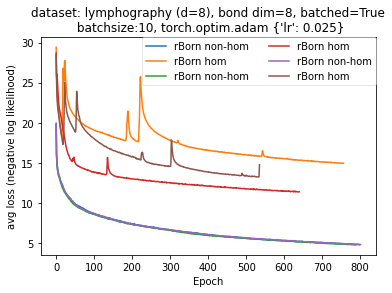

In [19]:
dataset = 'lymphography'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
arBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
arBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
brBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
brBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
crBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
crBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)
# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)

lossvals = train_models(
    [arBorn_s, arBorn_s_hom, brBorn_s, brBorn_s_hom, crBorn_s, crBorn_s_hom, 
    # cBorn_s, cBorn_s_hom
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, optimizer=torch.optim.Adam, lr=2.5e-2)

In [26]:
dataset = 'biofam'
X,d = load_dataset(dataset)
D = 2

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

Bmps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
Bmps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
BrBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
BrBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
BcBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)
BcBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)

lossvals_biofam = train_models(
    [Bmps_s, Bmps_s_hom, BrBorn_s, BrBorn_s_hom, 
    cBorn_s, cBorn_s_hom
    ],
    clamp_at=None, batchsize=50, max_epochs=1000, batched=True, verbose=False, optimizer=torch.optim.Adam, lr=1e-3)

╭──biofam
│ data shape:(2000, 16)
│ range of X values: 0 -- 7
╰───────────────────
dataset: biofam
╭───────────────────────────batched=True
│Training Positive MPS, Non-homogeneous, on cpu
│         batchsize:50, torch.optim.adam, {'lr': 0.001}.


KeyboardInterrupt: 

In [ ]:
dataset = 'biofam'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
# cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)
# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)

lossvals_biofam = train_models(
    [mps_s, mps_s_hom, rBorn_s, rBorn_s_hom, 
    #cBorn_s, cBorn_s_hom
    ],
    clamp_at=None, batchsize=10, max_epochs=500, batched=True, verbose=False, optimizer=torch.optim.Adam, lr=1e-3)

## Useful things?

In [ ]:
# Testing item selection

d=6
bs=3
slen=5
D=2

X = torch.randint(d,(bs,slen))
print(X)
weights = torch.arange(bs*slen*d*D*D).view(bs,slen,d,D,D)#.type(torch.cfloat)
# print(weights)
# what we want to do is, 
# in the bth batch and the ith core, 
# choose the X[b,i]th weight element
print("Selected weight items:")
for b, _ in enumerate(weights):
    for i, _ in enumerate(weights[b]):
        print(weights[b,i,X[b,i]])
    print()

# using a one-hot encoding of X, a tensor Xh of shape [bs,slen,d]
Xh = torch.nn.functional.one_hot(X, num_classes=d)
print("weights' shape", weights.shape)
print("1hot obs shape", Xh.shape)
# for b,_ in enumerate(ww):
#     print((ww[b] * XXh[b][:, :,None,None]).sum(1))
selected = (weights * Xh[:, :, :, None, None]).sum(2)
print("Selected weight items:")
print(selected.shape)
print(selected)

In [ ]:
# # torch.autograd.set_detect_anomaly(True)
# def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
#     trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
#     optimizer = torch.optim.Adadelta(self.parameters(), **optim_kwargs)
#     early_stopping_threshold = 1e-6 # min difference in epoch loss 
#     loss_values = [] # store by-epoch avg loss values
#     print(f'╭───────────────────────────\n│Training {self.name},')
#     print(f'│         batchsize:{batchsize}, {optimizer.__module__}, {optim_kwargs}.')
#     av_batch_loss_running = -1e4
#     with tqdm(range(max_epochs), unit="epoch", leave=True) as tepochs:
#         for epoch in tepochs:
#             batch_loss_list = []
#             with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
#                 for batch in tepoch:
#                     for pindex, p in enumerate(self.parameters()):
#                         if torch.isnan(p).any():
#                             pnames = list(self.state_dict().keys())
#                             print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                             print(f"└────Stopped before epoch {epoch}. NaN in weights {pnames[pindex]}!")
#                             if plot:
#                                 plt.plot(loss_values)
#                                 plt.show()
#                             return loss_values
#                     self.zero_grad()
#                     neglogprob = 0
#                     for x in batch:
#                         out = self(x)
#                         neglogprob -= out
#                     loss = neglogprob / len(batch)
#                     loss.backward()
#                     # for pindex, p in enumerate(self.parameters()):
#                     #     if torch.isnan(p.grad).any():
#                     #         pnames = list(self.state_dict().keys())
#                     #         print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                     #         print(f"└────Stopped. NaN value in gradient for {pnames[pindex]}!")
#                     #         if plot:
#                     #             plt.plot(loss_values)
#                     #             plt.show()
#                     #         return loss_values
#                     optimizer.step()
#                     tepoch.set_postfix(loss=loss.item())
#                     batch_loss_list.append(loss.item())
#                 av_batch_loss = torch.Tensor(batch_loss_list).mean().item()
#                 loss_values.append(av_batch_loss)
#                 tepochs.set_postfix(av_batch_loss=av_batch_loss)
#                 if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
#                     print(f"├────Early stopping after epoch {epoch}/{max_epochs}.")
#                     break
#                 av_batch_loss_running = av_batch_loss
#     print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#     if plot:
#         plt.plot(loss_values)
#         plt.show()
#     print('│ Finished training.\n╰───────────────────────────\n')
#     return loss_values

# def train_models(models, batchsize, max_epochs, **optim_kwargs):
#     print(f"dataset: {dataset}")
#     models_loss_values={}
#     for model in models:
#         loss_values = train(model, X, batchsize=batchsize, plot=False, max_epochs = max_epochs, **optim_kwargs)
#         plt.plot(loss_values, label=model.name)
#         plt.ylabel('avg loss (NLL)')
#         plt.xlabel('Epoch')
#         plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optim_kwargs}")
#         models_loss_values[f"{model.name}"]=loss_values
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.show()
#     return models_loss_values

In [ ]:

# def clip_grad(grad, clip_val, param_name, verbose=False):
#     """Clip the gradients, to be used as a hook during training."""
#     if torch.isnan(grad).any():
#         print(f"├─NaN value in gradient of {param_name}, {grad.size()}")
#     if grad.dtype==torch.cfloat:
#         for ext, v in [("min", grad.real.min()),("max", grad.real.max())]:
#             if verbose and abs(v) > clip_val:
#                 print(f"│(clipping {param_name} real {ext} {v:.2} to size {clip_val})")
#         for ext, v in [("min", grad.imag.min()),("max", grad.imag.max())]:
#             if verbose and abs(v) > clip_val:
#                 print(f"│(clipping {param_name} imag {ext} {1.j*v:.2} to size {clip_val})")
#         clipped_grad = torch.complex(grad.real.clamp(-clip_val, clip_val),
#                                      grad.imag.clamp(-clip_val, clip_val))
#     else:
#         for ext, v in [("min", grad.min()),("max", grad.max())]:
#             if verbose and abs(v) > clip_val:
#                 print(f"│(clipping {param_name} {ext} {v:.2} to size {clip_val})")
#         clipped_grad = torch.clamp(grad, -clip_val, clip_val)
#     return clipped_grad

# print(f"Models: D={D}, d={d}")
# for model in (*models, *models_hom):
#     print(f"\t{model.core.shape} model type: {model.name}")
#     for param_index, p in enumerate(model.parameters()):
#         pnames = list(model.state_dict().keys())
#         p.register_hook(lambda grad: clip_grad(grad, 1000, pnames[param_index], verbose=True))
#         if torch.isnan(p).any():
#             print(f"{pnames[param_index]} contains a NaN value!")



In [ ]:
# dataset = 'biofam'
# X,d = load_dataset(dataset)
# D = 8

# wr = noisy # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# mps      = PosMPS(X, d, D,                     homogeneous=False, log_stability=False,  w_randomization=wr)
# mps_hom  = PosMPS(X, d, D,                     homogeneous=True,  log_stability=False,  w_randomization=wr)
# mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr)
# mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr)
# rBorn      = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=False,  w_randomization=wr) 
# rBorn_hom  = Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=False,  w_randomization=wr)
# rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr)
# rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr)
# cBorn      = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False,  w_randomization=wr)
# cBorn_hom  = Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=False,  w_randomization=wr)
# cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr)
# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr)

# models     = (
#     # rBorn, cBorn, mps, 
#     rBorn_s, cBorn_s, mps_s)
# models_hom = (
#     # rBorn_hom, cBorn_hom, mps_hom, 
#     rBorn_s_hom, cBorn_s_hom, mps_s_hom)
